# Preparation

data classes, general functions

In [314]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
#Used for sorted insertion in list 
import bisect

In [315]:
KNN_TRAIN = "./mnist_small/train.csv"
KNN_TEST = "./mnist_small/test.csv"

names = ["label"] + [f"Pix {i}" for i in range(28*28)]

train_pd = pd.read_csv(KNN_TRAIN, names=names)
test_pd = pd.read_csv(KNN_TEST, names=names)

In [316]:
train_pd

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [317]:
test_pd

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [318]:
def visualize_image(mnist_array: np.array):
    """Visualize the given flattened image from the mnist dataset with its expected label"""
    label = mnist_array[0]
    image = mnist_array[1:].reshape(28, 28)

    fig = plt.figure()
    plt.title(f"Handwritten [{label}]") 
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()
    

class KnnClassifier:
    """Class encapsulating the logic of the KNN algorithm"""
    labels: pd.DataFrame
    data: pd.DataFrame
    k: int

    def __init__(self, k: int) -> None:
        """Init the KNN classifier. Needs a vlaue for K (The neighboors to consider)"""
        self.k = k

    def distance_pix_intensity(self, image1: np.array, image2: np.array):
        """Compute the distance as the difference in intensity level pixel-wise"""
        #use numpy functions as they are made to be efficient with vecotrized input
        return np.sum(np.abs(np.subtract(image1, image2)))

    def train(self, train_df: pd.DataFrame):
        self.labels = train_df.pop('label')
        self.data = train_df
        print(f"KNN prepared with {len(self.data)} data")
    
    def classify_single_verbose(self, image_array: np.array) -> None:
        """Classify an image by performing the KNN on the training dataset. 
        Don't return anything, focus on displaying steps to verify function execution"""
        #Assume the MNIST format, extract expected label
        expected_label = image_array[0]
        print(f"Trying to correctly classify image with expected label [{expected_label}]")

        image = image_array[1:]
        #Compute distance over each DF line
        distances = []
        print(f"Computing distances...")
        for i, row in self.data.iterrows():
            distance = self.distance_pix_intensity(image, row)
            image_label = self.labels.loc[i]
            #Sorted insertion for optimization
            bisect.insort_left(distances, (distance, image_label))
        print(f"Sorted tuple of (distances, labels): {distances}")

        #As list is sorted by distance, finding the neihbourhood is both trivial and quick
        neighbourhood = distances[:self.k]
        labels = [label for _, label in neighbourhood]
        print(f"Significant labels with k={self.k}: {labels}")

        sorted_freq_labels = Counter(labels).most_common()
        print(f"Count: {sorted_freq_labels}")

        #Trival case: only one class
        if len(sorted_freq_labels) == 1:
            classified_label = sorted_freq_labels[0][0]
        #In case of tie: fallback to K=1
        elif sorted_freq_labels[0][1] == sorted_freq_labels[1][1]:
            print(f"Detected draw with at least two classes, fallback to k=1")
            classified_label = neighbourhood[0][1]
        #else simply take most common
        else:
            classified_label = sorted_freq_labels[0][0]
        
        print(f"Classified image as: {classified_label}")

    def classify_single(self, image_array: np.array, verbose: bool = False) -> int:
        """Classify an image by performing the KNN on a """
        #Assume the MNIST format, extract expected label
        expected_label = image_array[0]
        image = image_array[1:]

        #Compute distance over each DF line
        distances = []
        for i, row in self.data.iterrows():
            distance = self.distance_pix_intensity(image, row)
            image_label = self.labels.loc[i]
            #Sorted insertion for optimization
            bisect.insort_left(distances, (distance, image_label))

        #As list is sorted by distance, finding the neihbourhood is both trivial and quick
        neighbourhood = distances[:self.k]
        labels = [label for _, label in neighbourhood]
        sorted_freq = Counter(labels).most_common()

    def classify_dataset(self, dataset: pd.DataFrame):
        pass

# Manual Test
First, let's try our solution and see with a few numbers if the mecanism is in place

In [319]:
train_pd

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [320]:
sample = train_pd.sample()
sample

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
740,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [321]:
sample_np = sample.to_numpy()[0]
sample_np

array([  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 107, 118, 118, 158, 248,
       147, 118,  33,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  49, 232, 252, 25

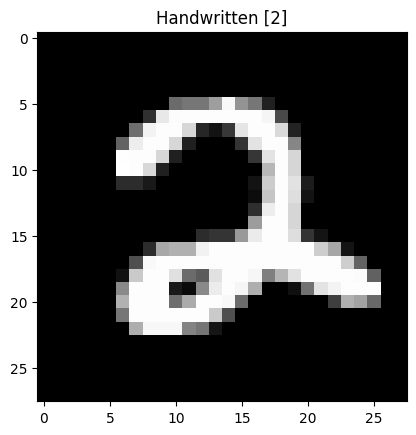

In [322]:
visualize_image(sample_np)

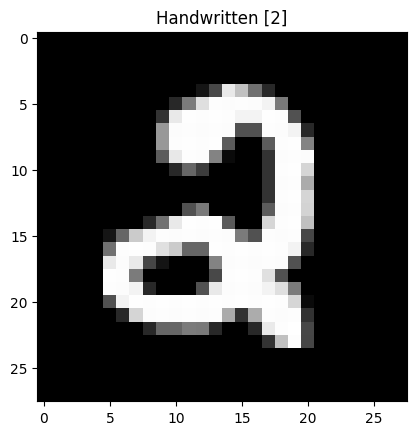

In [323]:
visualize_image(test_pd.sample().to_numpy()[0])

In [324]:
knnClassifier = KnnClassifier(k = 5)
knnClassifier.train(train_pd)

KNN prepared with 1000 data


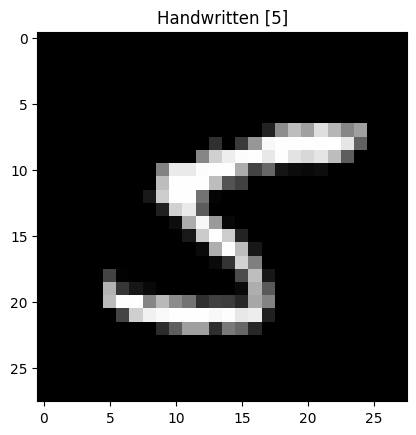

In [325]:
test_image = test_pd.sample().to_numpy()[0]
visualize_image(test_image)

In [326]:
knnClassifier.classify_single_verbose(test_image)

Trying to correctly classify image with expected label [5]
Computing distances...
Sorted tuple of (distances, labels): [(12358, 5), (14219, 5), (15870, 5), (15877, 5), (16945, 5), (18088, 5), (18190, 5), (18932, 5), (18957, 5), (19020, 5), (19417, 5), (19549, 5), (19994, 6), (20035, 5), (20196, 5), (20438, 5), (20454, 1), (20551, 4), (20750, 1), (20766, 5), (20789, 1), (20801, 1), (20980, 9), (21090, 5), (21111, 9), (21201, 1), (21232, 1), (21291, 8), (21308, 1), (21343, 7), (21364, 9), (21414, 7), (21473, 1), (21521, 1), (21538, 7), (21587, 1), (21615, 1), (21629, 4), (21672, 1), (21673, 7), (21728, 9), (21734, 8), (21738, 1), (21751, 3), (21767, 9), (21926, 5), (21929, 1), (21961, 7), (21968, 1), (22100, 7), (22116, 5), (22163, 4), (22171, 1), (22177, 1), (22189, 8), (22228, 1), (22288, 1), (22291, 4), (22316, 1), (22349, 5), (22362, 1), (22428, 9), (22436, 4), (22473, 9), (22478, 5), (22482, 7), (22509, 7), (22516, 1), (22557, 1), (22558, 1), (22568, 1), (22591, 1), (22595, 1), (225

IndexError: list index out of range